# STABLE DIFFUSION
### `DL Course, Dr. Soleymani`
#### Homework 5
*`Full Name:`* Ehsan Hassanbeygi

*`SID:`* 402211723


## What is Stable Diffusion


Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) and [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). for more information.



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

## Setup & Imports

In [3]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)

Thu Jun 20 13:50:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
!pip install -qqU --upgrade transformers==4.40.0 diffusers==0.27.2 ftfy==6.2.0 accelerate datasets bitsandbytes --use-deprecated=legacy-resolver

In [7]:
from argparse import Namespace
import math
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import autocast
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    PNDMScheduler,
    LMSDiscreteScheduler,
    DDPMScheduler,
)
from accelerate import Accelerator
from accelerate.utils import set_seed
import bitsandbytes as bnb

In [8]:
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 50  # Number of denoising steps
guidance_scale = 8  # Scale for classifier-free guidance
generator = torch.manual_seed(32)  # Seed generator to create the inital latent noise
batch_size = 1
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# PART 1 (30 pts)




Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [9]:
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="vae"
)  # Load the autoencoder model which will be used to decode the latents into image space.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet"
)  # The UNet model for generating the latents
scheduler = LMSDiscreteScheduler.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="scheduler"
)
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [37]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(
            transforms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1
        )  # Note scaling
    return 0.18215 * latent.latent_dist.sample()


def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

### Classifier Free Guidance

By default, the model doesn't often do what we ask. If we want it to follow the prompt better, we use a hack called CFG.

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`


In [38]:
def prompt_to_emb(prompt):
    """
    # TODO: This function should take in a prompt (list of strings) and return concatenated unconditional text embedding and text embeddings (torch tensor) (10 pts)
      1. Tokenize the prompt using the tokenizer, ensuring it fits the model's maximum length. This includes padding, truncation, and conversion to PyTorch tensors.
      2. Generate unconditional input for the model.
      3. Compute the text embedding for the provided prompt and for the unconditional input. (Disable gradients!)
      4. Concatenate the unconditional embeddings with the text embedding

    """
    ###############################
    ###### YOUR CODE GOES HERE ####
    # step 1
    inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(torch_device)

    # step 2
    # Here we use an empty string as the unconditional prompt
    uncond_input = tokenizer(
        [""],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    )
    uncond_ids = uncond_input.input_ids.to(torch_device)

    # Step 3
    with torch.no_grad():
        text_embeddings = text_encoder(input_ids)[0]
        uncond_embeddings = text_encoder(uncond_ids)[0]

    # Step 4
    uncond_embeddings = uncond_embeddings.repeat(input_ids.size(0), 1, 1)
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)

    ###############################

    return text_embeddings

In [39]:
def emb_to_latents(text_embeddings):
    """
    # TODO: This function should take in text embeddings (torch tensors) and return predicted latents. (20 pts)

        - Generate random latent noise for the input to the model.
        - Iterate over the scheduler timesteps.
            - Duplicate the random latent noise (to avoid doing two forward passes).
            - Scale the model input.
            - Generate noise predictions from the UNet model (disable gradients).
            - Apply classifier-free guidance scale.
            - Update the latent vectors using the scheduler step function.
    """
    scheduler.set_timesteps(num_inference_steps)

    ###############################
    ###### YOUR CODE GOES HERE ####
    # Step 1: Generate random latent noise
    batch_size = text_embeddings.size(0) // 2
    latents = torch.randn(
        (batch_size, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
    ).to(torch_device)

    latents = latents * scheduler.init_noise_sigma

    for t in tqdm(scheduler.timesteps):
        latent_input = torch.cat([latents] * 2)
        latent_input = scheduler.scale_model_input(latent_input, t)
        with torch.no_grad():
            noise_pred = unet(
                latent_input, t, encoder_hidden_states=text_embeddings
            ).sample

        # Step 5: Apply classifier-free guidance scale
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        # Step 6: Update the latent vectors using the scheduler step function
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    ###############################

    return latents

  0%|          | 0/50 [00:00<?, ?it/s]

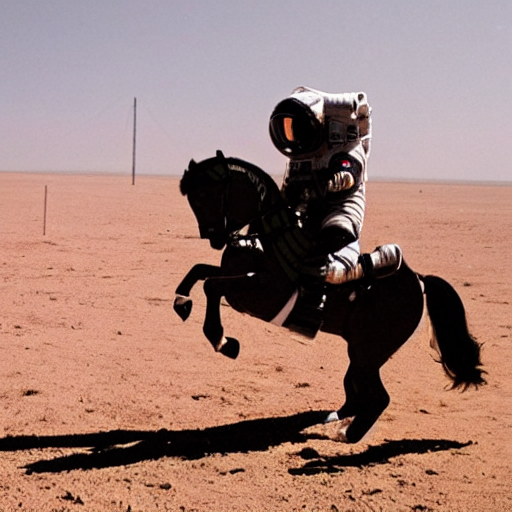

In [40]:
prompt = ["a photograph of an astronaut riding a horse"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

  0%|          | 0/50 [00:00<?, ?it/s]

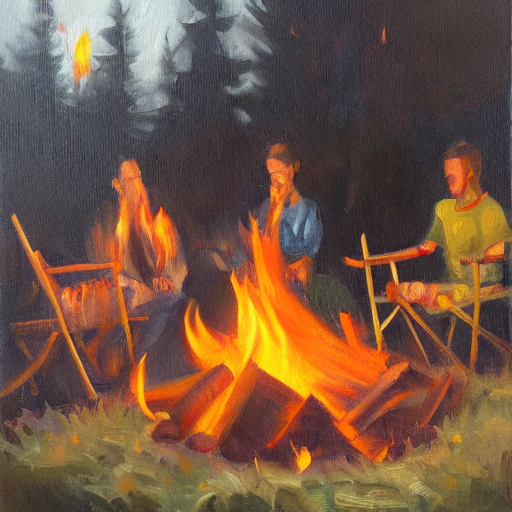

In [41]:
prompt = ["a campfire (oil on canvas)"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]

# PART 2 (20 pts)

#### Additional Guidance
 How can we add some extra control to this generation process?

At each step, we're going to use our model as before to predict the noise component of x. Then we'll use this to produce a predicted output image, and apply some loss function to this image.

This function can be anything, but let's demo with a super simple example. If we want images that have a lot of blue, we can craft a loss function that gives a high loss if pixels have a low blue component:


In [ ]:
def blue_loss(images):

    '''
        # TODO: this function should take in an images and return a scalar. (5 pts)
            - How far are the blue channel values to 0.9
    '''
    ###############################
    ###### YOUR CODE GOES HERE ####



    ###############################
    return loss

<ipython-input-12-b2dacecd5b85>:17: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.

  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 122.37715148925781

10 loss: 30.377273559570312

20 loss: 17.059274673461914

30 loss: 14.069783210754395

40 loss: 13.404562950134277


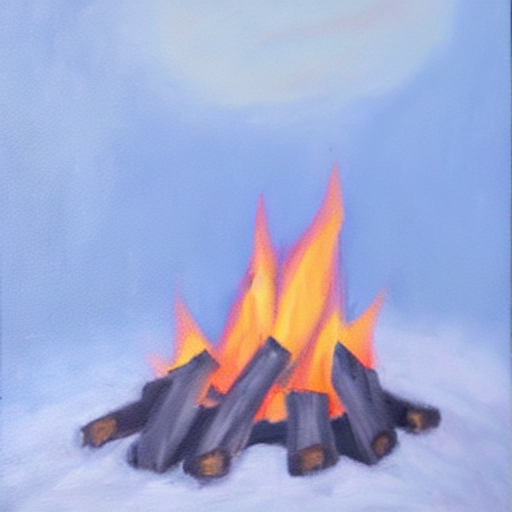

In [12]:
blue_loss_scale = 150


def emb_to_latents_with_blue_loss(text_embeddings):
  '''
    # TODO (15 pts)
      - Use the model to predict the noise component of x.
      - Produce a predicted output image every 5 steps.
      - Compute the blue loss function and apply it to the latents.
  '''

  scheduler.set_timesteps(num_inference_steps)

  ###############################
  ###### YOUR CODE GOES HERE ####


  
  ###############################
  return latents


text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents_with_blue_loss(text_embeddings)
latents_to_pil(latents)[0]

# PART 3 (50 pts)

### DreamBooth
In this part you'll **personalise a Stable Diffusion model by fine-tuning it on a handful of your own images.** To do so, we'll use a technique called [_DreamBooth_](https://arxiv.org/abs/2208.12242), which allows one to implant a subject (e.g. your pet or favourite dish) into the output domain of the model such that it can be synthesized with a _unique identifier_ in the prompt.


Before diving into this part, you should read the:

* DreamBooth [blog post](https://dreambooth.github.io/) to get a sense of what's possible with this technique
* Hugging Face [blog post](https://huggingface.co/blog/dreambooth) on best practices for fine-tuning Stable Diffusion with DreamBooth

The way DreamBooth works is as follows:

* Collect around 10-20 input images of a subject (e.g., your dog) and define a unique identifier [V] that refers to the subject. This identifier is usually some made up word like `flffydog` which is implanted in different text prompts at inference time to place the subject in different contexts.
* Fine-tune the diffusion model by providing the images together with a text prompt like "A photo of a [V] dog" that contains the unique identifier and class name (i.e., "dog" in this example).
* (Optionally) Apply a special _class-specific prior preservation loss_, which leverages the semantic prior that the model has on the class and encourages it to generate diverse instances belong to the subject's class by injecting the class name in the text prompt. In practice, this step is only really needed for human faces and can be skipped for the themes we'll be exploring in this hackathon.

An overview of the DreamBooth technique is shown in the image below:

![](https://dreambooth.github.io/DreamBooth_files/high_level.png)

### What can DreamBooth do?

Besides putting your subject in interesting locations, DreamBooth can be used for _**text-guided view synthesis**_, where the subject is viewed from different viewpoints

DreamBooth can also be used to modify properties of the subject, such as colour or mixing up animal species!



In [13]:
from datasets import load_dataset

dataset_id = "lewtun/corgi"         # You CAN CHANGE THIS TO YOUR DESIRED DATASET ADDRESS
dataset = load_dataset(dataset_id, split="train")
dataset

Generating train split:   0%|          | 0/5 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 5
})

### Displaying a Grid of Images
In this section, we will load a dataset of images, select a few samples, and display them in a grid using Python's PIL library.

In [18]:
from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 3
image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

#### Customizing and Displaying a Prompt for Your Subject 
In this section, we will create a customizable prompt that describes a specific concept. You can change the concept and type according to your needs, and this prompt can be used for generating images, captions, or other types of data related to your subject.

In [14]:
name_of_your_concept = "ccorgi"            # CHANGE THIS ACCORDING TO YOUR SUBJECT
type_of_thing = "dog"                      # CHANGE THIS ACCORDING TO YOUR SUBJECT
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: a photo of ccorgi dog


#### Custom Dataset Class for DreamBooth
In this section, we will define a `custom dataset` class called `DreamBoothDataset`. This class is designed to `preprocess images` and `tokenize prompts`for training a model using the DreamBooth method.

In [15]:
class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

In [16]:
train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)
train_dataset[0]

{'instance_images': tensor([[[ 0.7804,  0.7882,  0.8039,  ...,  0.7569,  0.7569,  0.7412],
          [ 0.7882,  0.7961,  0.8196,  ...,  0.7412,  0.7333,  0.7333],
          [ 0.7804,  0.7804,  0.7804,  ...,  0.7490,  0.7412,  0.7569],
          ...,
          [ 0.7255,  0.7255,  0.7255,  ...,  0.7412,  0.7412,  0.7333],
          [ 0.7098,  0.7255,  0.7333,  ...,  0.7333,  0.7255,  0.7333],
          [ 0.7098,  0.7098,  0.7176,  ...,  0.7333,  0.7255,  0.7255]],
 
         [[-0.0039, -0.0039,  0.0039,  ..., -0.2706, -0.2706, -0.2784],
          [-0.0039, -0.0039,  0.0196,  ..., -0.2863, -0.2863, -0.2863],
          [-0.0353, -0.0353, -0.0196,  ..., -0.2784, -0.2863, -0.2784],
          ...,
          [-0.3333, -0.3333, -0.3333,  ..., -0.2000, -0.2078, -0.2157],
          [-0.3490, -0.3333, -0.3255,  ..., -0.2314, -0.2314, -0.2235],
          [-0.3490, -0.3490, -0.3412,  ..., -0.2471, -0.2471, -0.2471]],
 
         [[-0.6000, -0.6000, -0.5843,  ..., -0.6549, -0.6627, -0.6706],
         

#### Custom Collate Function for Data Loading
In this section, we will define a `custom collate function` called collate_fn. This function is used to batch and preprocess individual examples from the DreamBoothDataset class when using a DataLoader in PyTorch.

In [17]:
def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

In [18]:
args = Namespace(
    resolution=512,
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=2e-06,
    max_train_steps=400,
    train_batch_size=1,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    seed=32,
    sample_batch_size=2,
    )


In [19]:
train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps
    )

unet.enable_gradient_checkpointing()
set_seed(args.seed)
optimizer_class = bnb.optim.AdamW8bit
optimizer = optimizer_class(
        unet.parameters(),              # Only optimize unet
        lr=args.learning_rate,
        )
unet, optimizer, train_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader
    )


noise_scheduler = DDPMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)


### Training Function for Optimizing the UNet Model
In this section, we define a function called `training_function` that trains and optimizes the UNet model using a provided dataloader. This function handles the training process, including converting images to latent space, adding noise, predicting noise residuals, and updating model parameters.

In [ ]:
def training_function(text_encoder, vae, unet, train_dataloader):

    '''
        # TODO: This funciton train and optimize only Unet model for personal model. (50 pts)

            - Sample random noise and timesteps, and add noise to the latents according to the forward diffusion process.
            - Get Text Embedding for Conditioning.
            - Predict Noise Residual and Compute Loss.
            - Backward Pass and Optimization. (Clip gradients if necessary)

    '''
    # Calculate the number of update steps per epoch and the total number of training epochs.

    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
    total_batch_size = (
        args.train_batch_size
        * accelerator.num_processes
        * args.gradient_accumulation_steps
    )
    # Initialize a progress bar to track training progress.

    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")

    # Set the global step counter to zero.

    global_step = 0


 
    # Training loop: Iterate over epochs and batches, setting the UNet model to training mode.
    #                Accumulate gradients to optimize the model.

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215


                ###############################
                ###### YOUR CODE GOES HERE ####



                ###############################


            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()



The `notebook_launcher` function from the `accelerate` library is used to distribute and accelerate the execution of the `training_function`.

In [21]:
from accelerate import notebook_launcher

num_of_gpus = 1                 
notebook_launcher(
    training_function, args=(text_encoder, vae, unet, train_dataloader), num_processes=num_of_gpus
)

Launching training on one GPU.


  0%|          | 0/400 [00:00<?, ?it/s]

In [22]:
scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
unet = accelerator.unwrap_model(unet)

<ipython-input-8-8092fd587bf1>:20: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.

  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

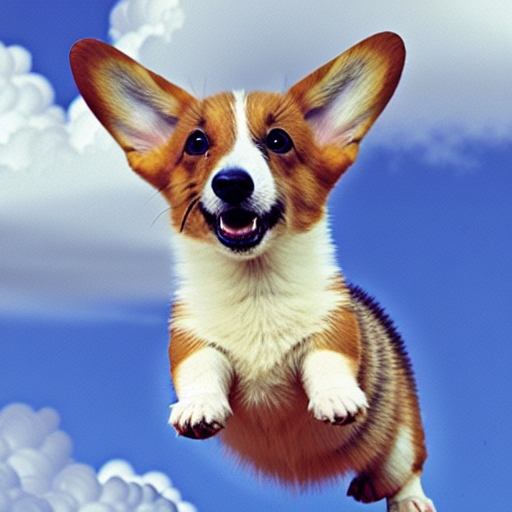

In [28]:
prompt = [f"a photo of {name_of_your_concept} {type_of_thing} flying in the sky"]
text_embeddings = prompt_to_emb(prompt)
latents = emb_to_latents(text_embeddings)
image = latents_to_pil(latents)
image[0]